# Guide for hera_sim Defaults and Simulator

This notebook is intended to be a guide for interfacing with the `hera_sim.defaults` module and using the `hera_sim.Simulator` class with the `run_sim` class method.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml

import uvtools
import hera_sim
from hera_sim import Simulator
from hera_sim.data import DATA_PATH
from hera_sim.config import CONFIG_PATH
%matplotlib inline

/home/bobby/HERA/dev/sim_from_cmd/hera_sim/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of interfacing with the hera_sim package features.
  FutureWarning)


We'll be using the `uvtools.plot.waterfall` function a few times throughout the notebook, but with a standardized way of generating plots. So let's write a wrapper to make these plots nicer:

In [2]:
# let's wrap it so that it'll work on Simulator objects
def waterfall(sim, antpairpol):
    """
    For reference, sim is a Simulator object, and antpairpol is a tuple with the
    form (ant1, ant2, pol).
    """
    freqs = np.unique(sim.data.freq_array) * 1e-9 # GHz
    lsts = np.unique(sim.data.lst_array) # radians
    vis = sim.data.get_data(antpairpol)
    
    # extent format is [left, right, bottom, top], vis shape is (NTIMES,NFREQS)
    extent = [freqs.min(), freqs.max(), lsts.max(), lsts.min()]
    
    fig = plt.figure(figsize=(12,8))
    axes = fig.subplots(2,1, sharex=True)
    axes[1].set_xlabel('Frequency [GHz]', fontsize=12)
    for ax in axes:
        ax.set_ylabel('LST [rad]', fontsize=12)
        
    fig.sca(axes[0])
    cax = uvtools.plot.waterfall(vis, mode='log', extent=extent)
    fig.colorbar(cax, label=r'$\log_{10}(V$/Jy)')
    
    fig.sca(axes[1])
    cax = uvtools.plot.waterfall(vis, mode='phs', extent=extent)
    fig.colorbar(cax, label='Phase [rad]')
    
    plt.tight_layout()
    plt.show()

In [3]:
# while we're preparing things, let's make a dictionary of default settings for
# creating a Simulator object

# choose a modest number of frequencies and times to simulate
NFREQ = 128
NTIMES = 32

# choose the channel width so that the bandwidth is 100 MHz
channel_width = 1e8 / NFREQ

# use just two antennas
ants = {0:(20.0,20.0,0), 1:(50.0,50.0,0)}

# use cross- and auto-correlation baselines
no_autos = False

# actually make the dictionary of initialization parameters
init_params = {'n_freq':NFREQ, 'n_times':NTIMES, 'antennas':ants,
               'channel_width':channel_width, 'no_autos':no_autos}

In [4]:
# turn off warnings; remove this cell in the future when this isn't a feature
hera_sim.defaults._warn = False

## Defaults Basics

Let's first go over the basics of the `defaults` module. There are three methods that serve as the primary interface between the user and the `defaults` module: `set`, `activate`, and `deactivate`. These do what you'd expect them to do, but the `set` method requires a bit of extra work to interface with if you want to set custom default parameter values. We'll cover this later; for now, we'll see how you can switch between defaults characteristic to different observing seasons. Currently, we support default settings for the H1C observing season and the H2C observing season, and these may be accessed using the strings `'h1c'` and `'h2c'`, respectively.

In [5]:
# first, let's note that the defaults are initially deactivated
hera_sim.defaults._override_defaults

False

In [6]:
# so let's activate the season defaults
hera_sim.defaults.activate()
hera_sim.defaults._override_defaults

True

In [7]:
# now that the defaults are activated, let's see what some differences are

# note that the defaults object is initialized with H1C defaults, but let's
# make sure that it's set to H1C defaults in case this cell is rerun later
hera_sim.defaults.set('h1c')

h1c_beam = hera_sim.noise._get_hera_bm_poly()
h1c_bandpass = hera_sim.sigchain._get_hera_bandpass()

# now change the defaults to the H2C observing season
hera_sim.defaults.set('h2c')

h2c_beam = hera_sim.noise._get_hera_bm_poly()
h2c_bandpass = hera_sim.sigchain._get_hera_bandpass()

# now compare them
print("H1C Defaults:\n \nBeam Polynomial: \n{}\nBandpass Polynomial: \n{}\n".format(h1c_beam, h1c_bandpass))
print("H2C Defaults:\n \nBeam Polynomial: \n{}\nBandpass Polynomial: \n{}\n".format(h2c_beam, h2c_bandpass))

H1C Defaults:
 
Beam Polynomial: 
[ 8.07774113e+08 -1.02194430e+09  5.59397878e+08 -1.72970713e+08
  3.30317669e+07 -3.98798031e+06  2.97189690e+05 -1.24980700e+04
  2.27220000e+02]
Bandpass Polynomial: 
[-2.04689451e+06  1.90683718e+06 -7.41348361e+05  1.53930807e+05
 -1.79976473e+04  1.12270390e+03 -2.91166102e+01]

H2C Defaults:
 
Beam Polynomial: 
[ 1.36744227e+13 -2.55445530e+13  2.14955504e+13 -1.07620674e+13
  3.56602626e+12 -8.22732117e+11  1.35321508e+11 -1.59624378e+10
  1.33794725e+09 -7.75754276e+07  2.94812713e+06 -6.58329699e+04
  6.52944619e+02]
Bandpass Polynomial: 
[ 1.56076423e+17 -3.03924841e+17  2.72553042e+17 -1.49206626e+17
  5.56874144e+16 -1.49763003e+16  2.98853436e+15 -4.48609479e+14
  5.07747935e+13 -4.29965657e+12  2.67346077e+11 -1.18007726e+10
  3.48589690e+08 -6.15315646e+06  4.88747021e+04]



In [8]:
# another thing
fqs = np.linspace(0.1,0.2,1024)
lsts = np.linspace(0,2*np.pi,100)

noise = hera_sim.noise.thermal_noise

hera_sim.defaults.set('h1c')
np.random.seed(0)
h1c_noise = noise(fqs,lsts)

hera_sim.defaults.set('h2c')
np.random.seed(0)
h2c_noise = noise(fqs,lsts)
np.random.seed(0)
still_h2c_noise = noise(fqs,lsts)

# passing in a kwarg
np.random.seed(0)
other_noise = noise(fqs,lsts,omega_p=np.ones(fqs.size))

# check things
print("H1C noise identical to H2C noise? {}".format(np.all(h1c_noise==h2c_noise)))
print("H2C noise identical to its other version? {}".format(np.all(h2c_noise==still_h2c_noise)))
print("Either noise identical to other noise? {}".format(np.all(h1c_noise==other_noise)
                                                         or np.all(h2c_noise==other_noise)))

H1C noise identical to H2C noise? False
H2C noise identical to its other version? True
Either noise identical to other noise? False


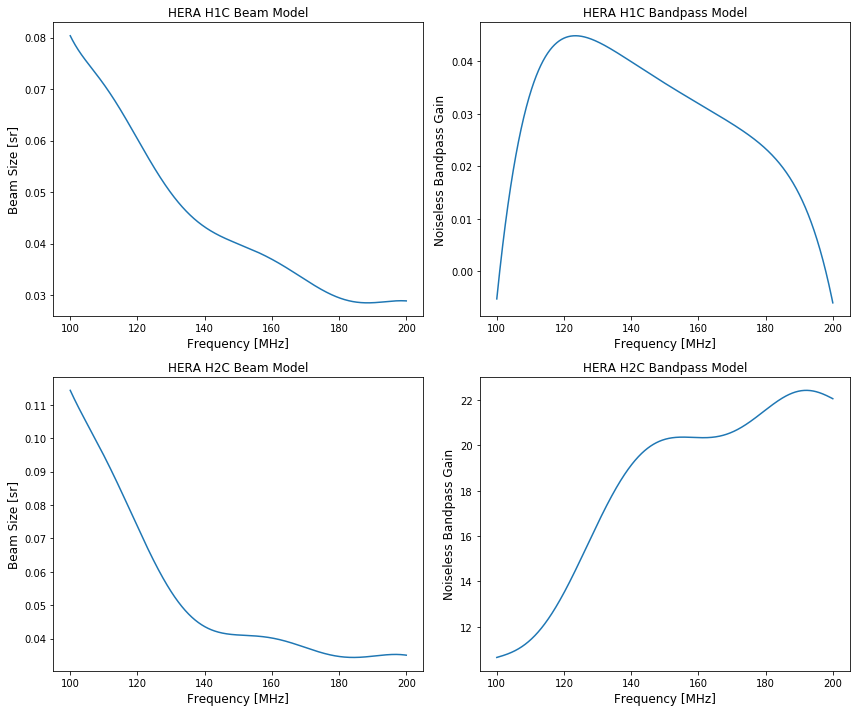

In [9]:
# check out what the beam and bandpass look like
seasons = ('h1c', 'h2c')
beams = {'h1c': h1c_beam, 'h2c': h2c_beam}
bps = {'h1c': h1c_bandpass, 'h2c': h2c_bandpass}
fig = plt.figure(figsize=(12,10))
axes = fig.subplots(2,2)
for j, ax in enumerate(axes[:,0]):
    seas = seasons[j]
    ax.set_xlabel('Frequency [MHz]', fontsize=12)
    ax.set_ylabel('Beam Size [sr]', fontsize=12)
    ax.set_title('HERA {} Beam Model'.format(seas.upper()), fontsize=12)
    ax.plot(fqs * 1e3, np.polyval(beams[seas], fqs))
for j, ax in enumerate(axes[:,1]):
    seas = seasons[j]
    ax.set_xlabel('Frequency [MHz]', fontsize=12)
    ax.set_ylabel('Noiseless Bandpass Gain', fontsize=12)
    ax.set_title('HERA {} Bandpass Model'.format(seas.upper()), fontsize=12)
    ax.plot(fqs * 1e3, np.polyval(bps[seas], fqs))
plt.tight_layout()
plt.show()

In [10]:
# let's look at the configuration that's initially loaded in
hera_sim.defaults._raw_config

{'foregrounds': {'diffuse_foreground': {'Tsky_mdl': <hera_sim.interpolators.Tsky at 0x7efc62e20b90>,
   'omega_p': <hera_sim.interpolators.Beam at 0x7efc62e19a90>}},
 'io': {'empty_uvdata': {'start_freq': 46920776.3671875,
   'channel_width': 122070.3125,
   'integration_time': 8.59}},
 'noise': {'_get_hera_bm_poly': {'bm_poly': 'HERA_H2C_BEAM_POLY.npy'},
  'resample_Tsky': {'Tsky': 180.0, 'mfreq': 0.18, 'index': -2.5},
  'sky_noise_jy': {'inttime': 8.59},
  'thermal_noise': {'Tsky_mdl': <hera_sim.interpolators.Tsky at 0x7efc62e2a4d0>,
   'omega_p': <hera_sim.interpolators.Beam at 0x7efc62e2aad0>,
   'Trx': 0,
   'inttime': 8.59}},
 'rfi': {'_get_hera_stations': {'rfi_stations': 'HERA_H2C_RFI_STATIONS.npy'},
  'rfi_impulse': {'chance': 0.001, 'strength': 20.0},
  'rfi_scatter': {'chance': 0.0001, 'strength': 10.0, 'std': 10.0},
  'rfi_dtv': {'freq_min': 0.174,
   'freq_max': 0.214,
   'width': 0.008,
   'chance': 0.0001,
   'strength': 10.0,
   'strength_std': 10.0}},
 'sigchain': {'_g

In [11]:
# and what about the set of defaults actually used?
hera_sim.defaults._config

{'Tsky_mdl': <hera_sim.interpolators.Tsky at 0x7efc62e2a4d0>,
 'omega_p': <hera_sim.interpolators.Beam at 0x7efc62e2aad0>,
 'start_freq': 46920776.3671875,
 'channel_width': 122070.3125,
 'integration_time': 8.59,
 'bm_poly': 'HERA_H2C_BEAM_POLY.npy',
 'Tsky': 180.0,
 'mfreq': 0.18,
 'index': -2.5,
 'inttime': 8.59,
 'Trx': 0,
 'rfi_stations': 'HERA_H2C_RFI_STATIONS.npy',
 'chance': 0.0001,
 'strength': 10.0,
 'std': 10.0,
 'freq_min': 0.174,
 'freq_max': 0.214,
 'width': 0.008,
 'strength_std': 10.0,
 'bandpass': 'HERA_H2C_BANDPASS.npy',
 'gain_spread': 0.1,
 'amplitude': 3.0,
 'amp': 0.0,
 'dly': 0.0,
 'phs': 0.0}

In [12]:
# let's make two simulator objects
sim1 = Simulator(**init_params)
sim2 = Simulator(**init_params)

In [13]:
# parameters for two different simulations
hera_sim.defaults.set('h1c')
sim1params = {'pntsrc_foreground': {},
              'noiselike_eor': {},
              'diffuse_foreground': {}}
hera_sim.defaults.set('h2c')
sim2params = {'pntsrc_foreground': {},
              'noiselike_eor': {},
              'diffuse_foreground': {}}
sim1.run_sim(**sim1params)
sim2.run_sim(**sim2params)

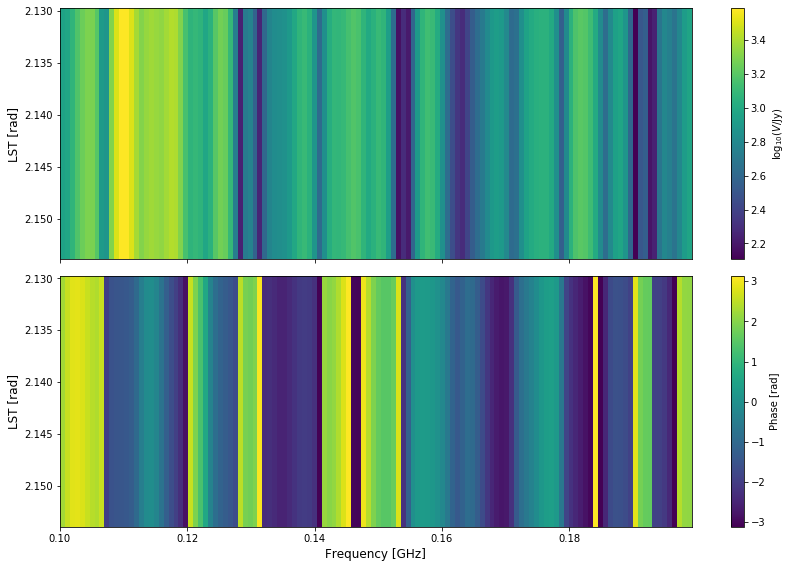

In [14]:
antpairpol = (0,1,'xx')
waterfall(sim1, antpairpol)

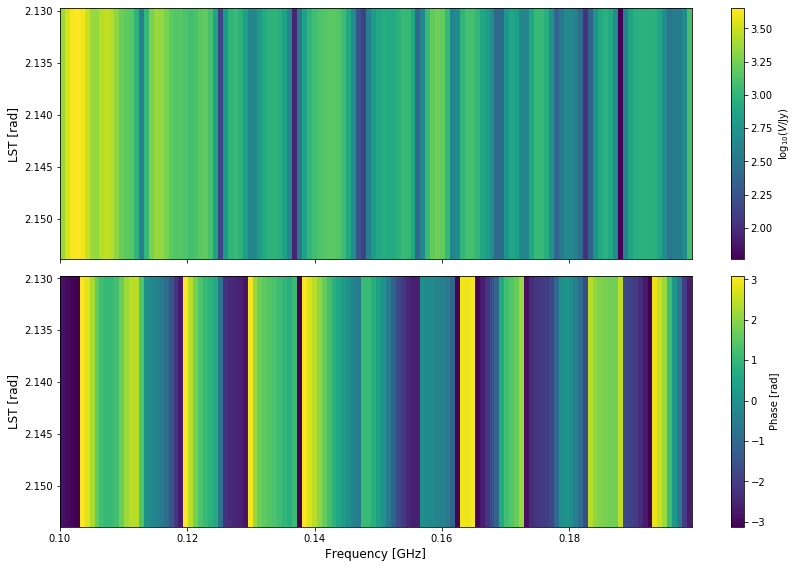

In [15]:
waterfall(sim2, antpairpol)